In [22]:
# nuclio: ignore
import nuclio

In [23]:
%nuclio config kind = "job"
%nuclio config spec.image = "mlrun/ml-models"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'mlrun/ml-models'


In [24]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import json
import os

from cloudpickle import dumps, load, dump

from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics

from typing import List
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact

from mlutils import (get_sample,
                     get_splits,
                     gen_sklearn_model,
                     create_class,
                     get_class_fit,
                     eval_class_model,
                     gcf_clear)

def train_model(
    context: MLClientCtx,
    model_pkg_class: str,
    dataset: DataItem,
    label_column: str = "labels",
    encode_cols: List[str] = [],
    sample: int = -1,
    test_size: float = 0.30,
    train_val_split: float = 0.75,
    rng: int = 1,
    model_filename: str = "model",
    models_dest: str = "",
    cmap = plt.cm.Blues,
    plots_dest: str = "plots",
    score_method: str = "micro",
    file_ext: str = "parquet",
    model_pkg_file: str = "",
    random_state: int = 1,
) -> None:
    """train a classifier.

    :param context:           the function context
    :param model_pkg_class:   the model to train, e.g, "sklearn.neural_networks.MLPClassifier", 
                              or json model config
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param encode_cols:       dictionary of names and prefixes for columns that are
                              to hot be encoded.
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param model_filename:    model file filename,
                              points to a directory
    :param test_size:         (0.05) test set size
    :param train_val_split:   (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param rng:               (1) sklearn rng seed
    :param models_dest:       models subfolder on artifact path
    :param cmap:              matplotlib `Colormap`
    :param plots_dest:        plot subfolder on artifact path
    :param score_method:      for multiclass classification
    
    :param file_ext:          format for test_set_key hold out data
    :param model_pkg_file:    json model config file                                  
    """
   # deprecate:
    models_dest = models_dest or "models"
    plots_dest = plots_dest or f"plots/{context.name}"
    
    # get a sample from the raw data
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # hot-encode
    if encode_cols:
        raw = pd.get_dummies(raw, 
                             columns=list(encode_cols.keys()), 
                             prefix=list(encode_cols.values()), 
                             drop_first=True)
    
    # split the sample into train validate, test and calibration sets:
    (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = \
        get_splits(raw, labels, 3, test_size, 1-train_val_split, random_state)
    
    test_set = pd.concat([xtest, ytest.to_frame()], axis=1)
    context.log_dataset('test_set', df=test_set, format=file_ext, index=False)

    if model_pkg_file:
        model_config = json.load(open(model_pkg_file, "r"))
    elif model_pkg_class:
        model_config = get_class_fit(model_pkg_class)
    else:
        raise ValueError('model_pkg_file or model_pkg_class must be provided')
    
    for k, v in context.parameters.items():
        if k.startswith('CLASS_'):
            model_config['CLASS'][k[6:]] = v
        if k.startswith('FIT_'):
            model_config['FIT'][k[4:]] = v

    model_config["FIT"].update({"X": xtrain,"y": ytrain.values})
    
    ClassifierClass = create_class(model_config["META"]["class"])
    model = ClassifierClass(**model_config["CLASS"])
    model.fit(**model_config["FIT"])
    
    # evaluate model
    eval_metrics = eval_class_model(context, xvalid, yvalid, model)

    # just do this inside log_model?
    model_plots = eval_metrics.pop("plots")
    model_tables = eval_metrics.pop("tables")
    for plot in model_plots:
        context.log_artifact(plot, local_path=f"{plots_dest}/{plot.key}.html")
    for tbl in model_tables:
        context.log_artifact(tbl, local_path=f"{plots_dest}/{plot.key}.csv")

    model_bin = dumps(model) # .get_booster())
    context.log_model("model", body=model_bin,
                      artifact_path=os.path.join(context.artifact_path, models_dest),
                      #model_dir=models_dest, 
                      model_file="model.pkl",
                      metrics=eval_metrics)

    # probably have it wrong, cant see them from log_model so try this:
    context.log_results(eval_metrics)

In [25]:
# nuclio: end-code

### mlconfig

In [26]:
from mlrun import mlconf
import os

mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'
mlconf.artifact_path = mlconf.artifact_path or f'{os.environ["HOME"]}/artifacts'

### save

In [27]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("sklearn_classifier")

# add metadata (for templates and reuse)
fn.spec.default_handler = "train_model"
fn.spec.description = "train any classifier using scikit-learn's API"
fn.metadata.categories = ["ml", "training"]
fn.metadata.labels = {"author": "yjb", "framework": "sklearn"}
fn.export("function.yaml")

[mlrun] 2020-05-24 17:27:59,509 function spec saved to path: function.yaml


In [28]:
from mlutils import get_vol_mount
fn.apply(get_vol_mount())

## tests

In [29]:
## TODO: CLASS_xxx that aren't valid for a give algo, just report and skip, not fail

from mlrun import NewTask    

task_params = {
    "name" : "",
    "params" : {
        # CHOOSE YOUR MODEL AND CHANGE SOME DEFAULT PARAMETERS
       # "model_pkg_class"    : model_class,
        "CLASS_random_state" : 1,
        #"CLASS_probability"  : True,  # USE ONLY FOR SVC
        "sample"             : -1,
        "label_column"       : "labels",
        "test_size"          : 0.30,
        "train_val_split"    : 0.25,
        "rng"                : 1,
        "models_dest"        : 'sklearn_models'}}

### run locally

sklearn.ensemble.RandomForestClassifier
[mlrun] 2020-05-24 17:27:59,560 starting run sklearn_ensemble_RandomForestClassifier uid=d15545f7a61e4d49a176c0457a25f3de  -> http://mlrun-api:8080
[mlrun] 2020-05-24 17:27:59,654 log artifact test_set at /User/artifacts/test_set.parquet, size: 4572, db: Y
[mlrun] 2020-05-24 17:28:00,084 log artifact confusion-matrix-normalized at /User/artifacts/plots/confusion-matrix-normalized.html, size: 1766, db: Y
[mlrun] 2020-05-24 17:28:00,162 log artifact feature-importances at /User/artifacts/plots/feature-importances.html, size: 7902, db: Y
[mlrun] 2020-05-24 17:28:00,251 log artifact precision-recall-multiclass at /User/artifacts/plots/precision-recall-multiclass.html, size: 38926, db: Y
[mlrun] 2020-05-24 17:28:00,329 log artifact roc-multiclass at /User/artifacts/plots/roc-multiclass.html, size: 19781, db: Y
[mlrun] 2020-05-24 17:28:00,346 log artifact feature-importances-tbl at /User/artifacts/plots/roc-multiclass.csv, size: 162, db: Y
[mlrun] 2020

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...7a25f3de,0,May 24 17:27:59,completed,sklearn_ensemble_RandomForestClassifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-67c88b95d4-crdhq,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifiermodels_dest=sklearn/sklearn.ensemble.RandomForestClassifier,test-accuracy=0.8846153846153846test-error=0.11538461538461539auc-micro=0.9933431952662722auc-weighted=1.0f1-score=0.8846153846153846precision_score=0.8846153846153846recall_score=0.8846153846153846,test_setconfusion-matrix-normalizedfeature-importancesprecision-recall-multiclassroc-multiclassfeature-importances-tblmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run d15545f7a61e4d49a176c0457a25f3de --project default , !mlrun logs d15545f7a61e4d49a176c0457a25f3de --project default
[mlrun] 2020-05-24 17:28:00,451 run executed, status=completed
sklearn.linear_model.LogisticRegression
[mlrun] 2020-05-24 17:28:00,457 starting run sklearn_linear_model_LogisticRegression uid=fd703f271b254293aa4128639e60c4e1  -> http://mlrun-api:8080


/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[mlrun] 2020-05-24 17:28:00,547 log artifact test_set at /User/artifacts/test_set.parquet, size: 4572, db: Y
[mlrun] 2020-05-24 17:28:00,939 log artifact confusion-matrix-normalized at /User/artifacts/plots/confusion-matrix-normalized.html, size: 1766, db: Y
[mlrun] 2020-05-24 17:28:01,021 log artifact precision-recall-multiclass at /User/artifacts/plots/precision-recall-multiclass.html, size: 39390, db: Y
[mlrun] 2020-05-24 17:28:01,089 log artifact roc-multiclass at /User/artifacts/plots/roc-multiclass.html, size: 19865, db: Y
[mlrun] 2020-05-24 17:28:01,119 log artifact model at /User/artifacts/sklearn/sklearn.linear_model.LogisticRegression/, size: 780, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...9e60c4e1,0,May 24 17:28:00,completed,sklearn_linear_model_LogisticRegression,v3io_user=adminkind=handlerowner=adminhost=jupyter-67c88b95d4-crdhq,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionmodels_dest=sklearn/sklearn.linear_model.LogisticRegression,test-accuracy=0.9230769230769231test-error=0.07692307692307693auc-micro=0.9940828402366865auc-weighted=1.0f1-score=0.9230769230769231precision_score=0.9230769230769231recall_score=0.9230769230769231,test_setconfusion-matrix-normalizedprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run fd703f271b254293aa4128639e60c4e1 --project default , !mlrun logs fd703f271b254293aa4128639e60c4e1 --project default
[mlrun] 2020-05-24 17:28:01,166 run executed, status=completed
sklearn.ensemble.AdaBoostClassifier
[mlrun] 2020-05-24 17:28:01,173 starting run sklearn_ensemble_AdaBoostClassifier uid=b38c3119e90d4847872a40e2a8e0fce2  -> http://mlrun-api:8080
[mlrun] 2020-05-24 17:28:01,257 log artifact test_set at /User/artifacts/test_set.parquet, size: 4572, db: Y
[mlrun] 2020-05-24 17:28:01,623 log artifact confusion-matrix-normalized at /User/artifacts/plots/confusion-matrix-normalized.html, size: 1766, db: Y
[mlrun] 2020-05-24 17:28:01,710 log artifact feature-importances at /User/artifacts/plots/feature-importances.html, size: 7902, db: Y
[mlrun] 2020-05-24 17:28:01,824 log artifact precision-recall-multiclass at /User/artifacts/plots/precision-recall-multiclass.html, size: 38894, db: Y
[mlrun] 2020-05-24 17:28:01,89

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...a8e0fce2,0,May 24 17:28:01,completed,sklearn_ensemble_AdaBoostClassifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-67c88b95d4-crdhq,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifiermodels_dest=sklearn/sklearn.ensemble.AdaBoostClassifier,test-accuracy=0.8846153846153846test-error=0.11538461538461539auc-micro=0.9933431952662721auc-weighted=1.0f1-score=0.8846153846153846precision_score=0.8846153846153846recall_score=0.8846153846153846,test_setconfusion-matrix-normalizedfeature-importancesprecision-recall-multiclassroc-multiclassfeature-importances-tblmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run b38c3119e90d4847872a40e2a8e0fce2 --project default , !mlrun logs b38c3119e90d4847872a40e2a8e0fce2 --project default
[mlrun] 2020-05-24 17:28:01,998 run executed, status=completed


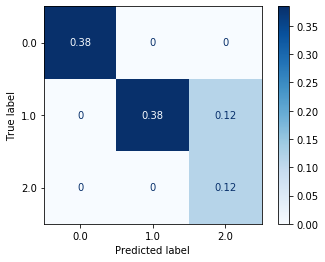

<Figure size 432x288 with 0 Axes>

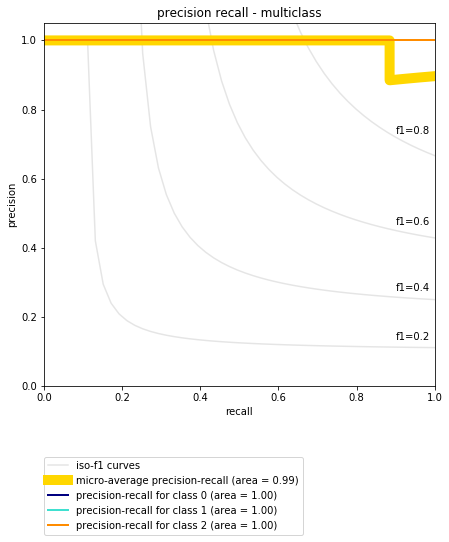

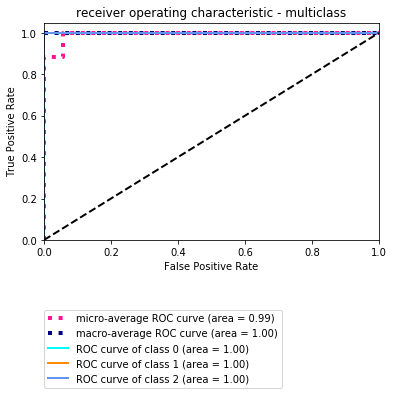

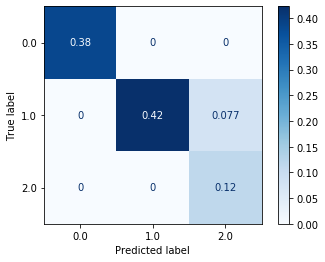

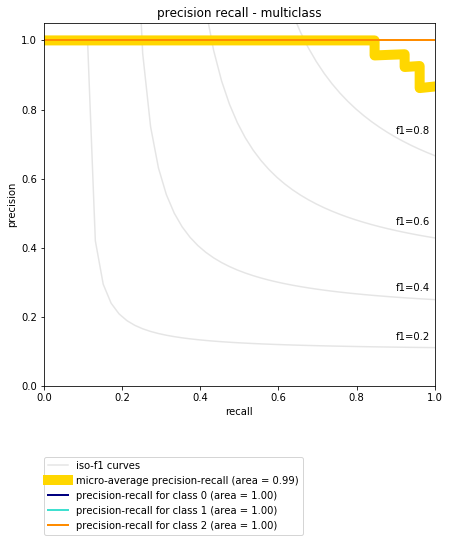

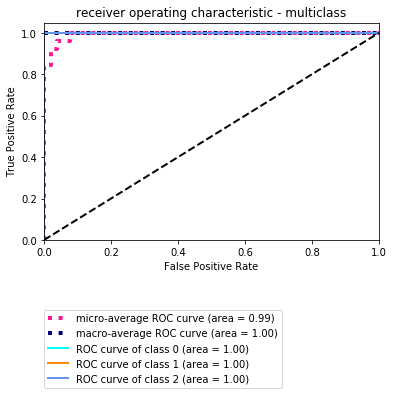

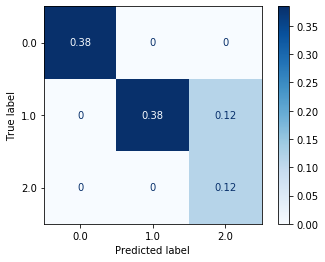

<Figure size 432x288 with 0 Axes>

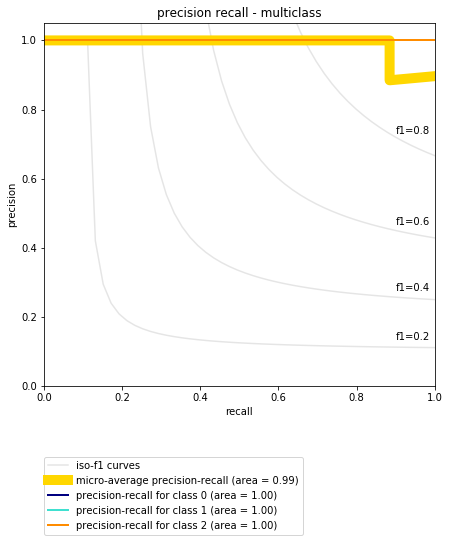

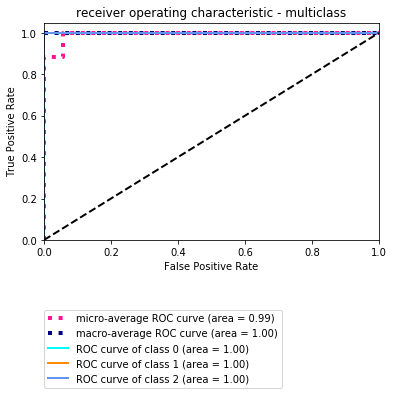

In [30]:
MODELS = ["sklearn.ensemble.RandomForestClassifier", 
         "sklearn.linear_model.LogisticRegression",
         "sklearn.ensemble.AdaBoostClassifier"]

from mlrun import run_local

for model in MODELS:
    print(model)
    task_params.update({"params":{"model_pkg_class":model, "models_dest" : f'sklearn/{model}'}})
    task = NewTask(**task_params)
    run_local(task,
              handler=train_model,
              name=model.replace('.', '_'),
              inputs={"dataset"  : mlconf.artifact_path + "/iris.parquet"})

## tests

In [31]:
df = pd.read_parquet('/User/artifacts/test_set.parquet')

In [32]:
df.head(4)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),labels
0,6.7,3.0,5.2,2.3,2.0
1,5.5,2.5,4.0,1.3,1.0
2,6.5,2.8,4.6,1.5,1.0
3,6.7,3.0,5.0,1.7,1.0


In [33]:
labels = df.pop('labels')

In [34]:
adamodel = load(open('/User/artifacts/sklearn/sklearn.ensemble.AdaBoostClassifier/model.pkl', 'rb'))

In [35]:
adamodel

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [36]:
labels==np.argmax(adamodel.predict_proba(df), axis=1)

0      True
1      True
2      True
3     False
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
40     True
41     True
42     True
43     True
44     True
Name: labels, dtype: bool

In [37]:
logregmodel = load(open('/User/artifacts/sklearn/sklearn.linear_model.LogisticRegression/model.pkl', 'rb'))

In [38]:
logregmodel

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
labels==np.argmax(logregmodel.predict_proba(df), axis=1)

0      True
1      True
2      True
3     False
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
40     True
41     True
42     True
43     True
44     True
Name: labels, dtype: bool

In [40]:
rfmodel = load(open('/User/artifacts/sklearn/sklearn.ensemble.RandomForestClassifier/model.pkl', 'rb'))

In [41]:
rfmodel

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [42]:
labels==np.argmax(rfmodel.predict_proba(df), axis=1)

0      True
1      True
2      True
3     False
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
40     True
41     True
42     True
43     True
44     True
Name: labels, dtype: bool